In [ ]:
#解决过拟合——权重衰减
#权重衰减等价于 L2范数正则化（regularization）
#通过控制参数选择的值的范围来控制模型容量 min l(w,b) subject to ||w||^2<Θ，Θ越小正则越强
#一般表达为：min l(w,b) + λ/2||w||^2 超参λ控制正则化程度
#对以上式子进行梯度计算，然后更新w, wt+1 = (1-ηλ)wt - η(∂l(wt,bt)/∂wt),ηλ<1这就叫权重衰减

In [14]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np
#生成数据
num_train,num_test,num_inputs,batch_size = 20,100,200,5 #故意把训练数据做小，这样容易过拟合
true_w,true_b = torch.ones((num_inputs,1)) *0.01,0.05
features = torch.randn((num_train+num_test,num_inputs))
labels = torch.matmul(features,true_w) + true_b
labels += torch.tensor(np.random.normal(0,0.01,size = labels.size()),dtype=torch.float)
train_features,test_features = features[:num_train,:],features[num_train:,:]
train_labels,test_labels = labels[:num_train,:],labels[num_train:,:]


In [15]:
#初始化模型参数
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad = True)
    return [w,b]
def l2_penalty(w):
    return torch.sum(w.pow(2))/2


L2 norm of w: 0.046115465462207794


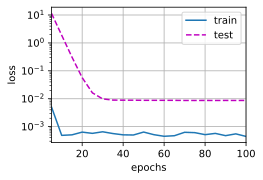

In [18]:
# batch_size, num_epochs, lr = 1, 100, 0.003
# net, loss = lambda X: d2l.linreg(X,w,b), d2l.squared_loss

# dataset = torch.utils.data.TensorDataset(train_features, train_labels)
# train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    batch_size, num_epochs, lr = 1, 100, 0.003
    net, loss = lambda X: d2l.linreg(X,w,b), d2l.squared_loss
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    train_ls, test_ls = [], []
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs]
                           ,legend=['train','test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l = l.sum()

            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
#         train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
#         test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
        if (epoch+1) % 5 == 0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
#     d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
#                  range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())
fit_and_plot(lambd=3)

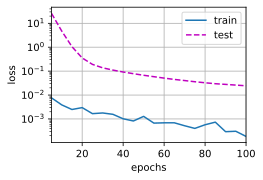

In [23]:
#也可以直接在构造优化器实例时通过weight_decay参数来指定权重衰减超参数。
#默认下，PyTorch会对权重和偏差同时衰减。
def fit_and_plot_pytorch(wd):
    w,b = init_params()
    batch_size, num_epochs, lr = 1, 100, 0.003
    net = nn.Sequential(nn.Linear(num_inputs,1))
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    trainer = torch.optim.SGD([{
        "params":net[0].weight,
        "weight_decay":wd},
        {"params": net[0].bias
    }],lr = lr)
    animator = d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs]
                           ,legend=['train','test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X),y)
            l.backward()
            trainer.step()
        if (epoch+1) % 5 == 0:
            animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))

fit_and_plot_pytorch(wd=3)
            